# Testat to get numbers from a sheet of paper

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import skimage.feature
import skimage.transform.hough_transform as ht
import matplotlib.patches as patches
from skimage.filters import threshold_otsu, threshold_local, try_all_threshold
import ipywidgets as widgets

## Load image

Helper to get a random picture to test the filter pipeline

In [2]:
def load_random_image(base_path: Path) -> np.ndarray:
        files = glob.glob(str(base_path / '*'))
        file = np.random.choice(files)
        return file

def load_hard_image(base_path: Path)-> np.ndarray:
    hard_images = [
        'IMG_20190312_183902.jpg',
        'IMG_20190312_183952.jpg',
        'IMG_20190325_190116.jpg',
        'IMG_20190312_183945.jpg',
    ]
    
    return np.random.choice([base_path / image for image in hard_images])
    
    
    
    
def load_image(base_path: Path, hard_image: bool = True, show_grayscale: bool = True) -> np.ndarray:
    
    if hard_image:
        file = load_hard_image(base_path)
    else:
        file = load_random_image(base_path)
        
    image = skimage.io.imread(file)
    grayed_image =  skimage.color.rgb2gray(image)
    
    if not show_grayscale:
        plt.imshow(image)
    else:
        plt.imshow(grayed_image, cmap="gray")
    return grayed_image

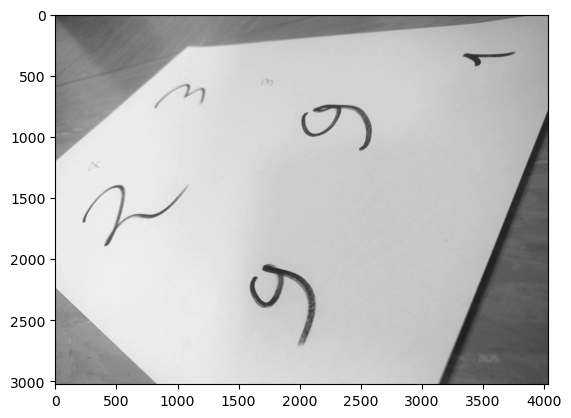

In [3]:
base_path = Path('Images')
loaded_image = load_image(base_path, hard_image = True)

In [4]:
image = loaded_image

## Blurring image

In [5]:
@widgets.interact(sigma = (1,21,2))
def f(sigma):
    blurred_image = skimage.filters.gaussian(image, sigma=sigma, mode='constant', cval=0.0)
    fig, (ax1,ax2) = plt.subplots(1, 2)
    ax1.imshow(image, cmap="gray", vmin=0, vmax=1)
    ax2.imshow(blurred_image, cmap="gray", vmin=0, vmax=1)

interactive(children=(IntSlider(value=11, description='sigma', max=21, min=1, step=2), Output()), _dom_classes…

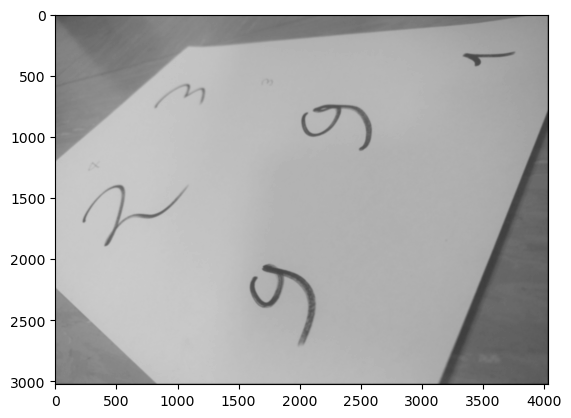

In [6]:
image = skimage.filters.gaussian(image, sigma=4, mode='constant', cval=0.0)
plt.imshow(image, cmap="gray", vmin=0, vmax=1)

## Thresholding

First we try all available thresholds...

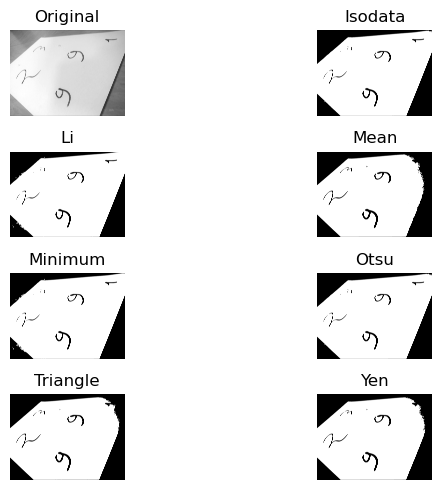

In [7]:
fig, ax = try_all_threshold(image, verbose=False)

In [8]:
def get_otsu_thresh(image: np.ndarray):
    thresh = threshold_otsu(image)
    binary = image > thresh
    plt.imshow(binary, cmap="gray")
    return binary
    
def get_local_thresh_image(image):
    block_size = 35
    local_thresh = threshold_local(image, block_size, offset=10)
    binary = image > local_thresh
    plt.imshow(binary, cmap="gray")
    return binary

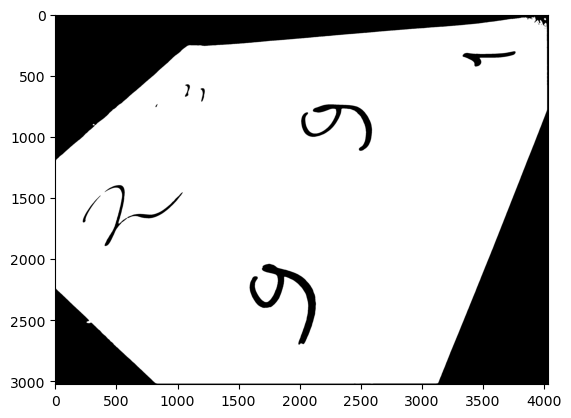

In [9]:
image = get_otsu_thresh(image)

## Watershed example

## Remove small countours with erosion

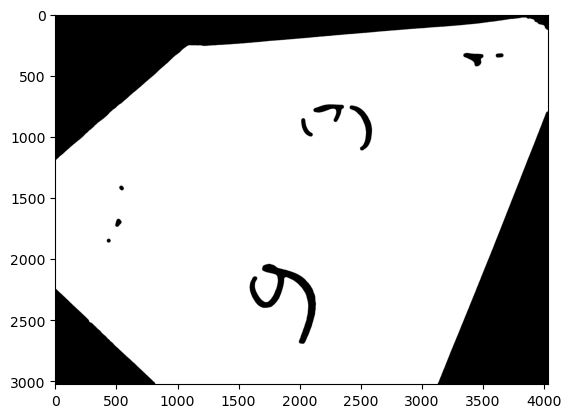

In [15]:
#image = skimage.morphology.area_opening(image)
image = skimage.morphology.dilation(image, skimage.morphology.disk(16))
image = skimage.morphology.erosion(image, skimage.morphology.disk(16))
plt.imshow(image, cmap='gray')

## Find biggest contour

In [11]:
def get_biggest_contour(thresh_image):

    fig, ax = plt.subplots()
    ax.imshow(thresh_image, cmap="gray")
    labels = skimage.measure.label(thresh_image)
    regions = skimage.measure.regionprops(labels)
    largest_region = regions[np.argmax([region.area for region in regions])]
    
    (min_row, min_col, max_row, max_col) = largest_region.bbox
    width = max_col - min_col
    height = max_row - min_row
    rect = patches.Rectangle((min_col,min_row),width,height,
                             linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
    plt.plot()
    mask_image = np.zeros_like(thresh_image)
    print(mask_image.shape)
    mask_image[min_row:max_row, min_col:max_col] = True
    return thresh_image & mask_image

(3024, 4032)


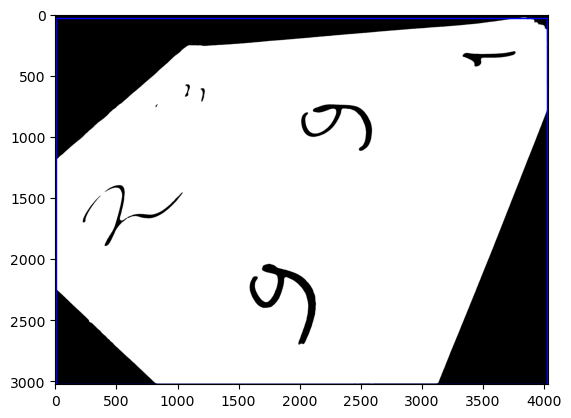

In [12]:
free_contour = get_biggest_contour(image)

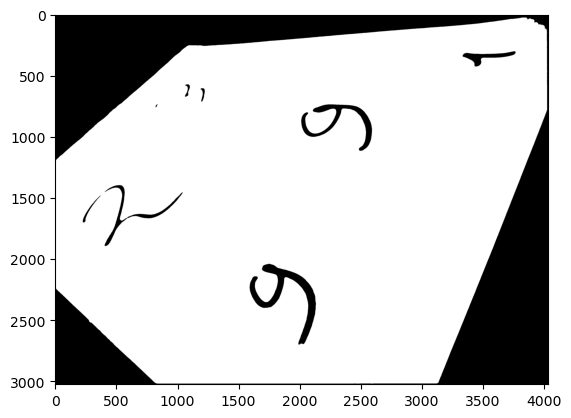

In [13]:
plt.imshow(free_contour, cmap="gray")

In [14]:
@widgets.interact(canny_sigma=(1,10), hough_threshold=(10,200,20))
def f(canny_sigma, hough_threshold):
    imedges = skimage.feature.canny(image, sigma=canny_sigma)
    lines = ht.probabilistic_hough_line(imedges,
                                        threshold=hough_threshold,
                                        seed=0)
    fig,(ax0,ax1) = plt.subplots(ncols=2, figsize=(12,8))
    ax0.imshow(image,cmap="gray")
    for ((x0,y0),(x1,y1)) in lines:
        ax0.plot([x0,x1],[y0,y1],'b-')
    ax1.imshow(imedges,cmap="gray")

interactive(children=(IntSlider(value=5, description='canny_sigma', max=10, min=1), IntSlider(value=90, descri…

In [17]:
image_edges = skimage.feature.canny(image, sigma=5)
lines = ht.probabilistic_hough_line(image_edges,
                                    threshold=90,
                                    seed=0)
print(lines)

[((3442, 2255), (3649, 1741)), ((3276, 2665), (3601, 1862)), ((3254, 2718), (3338, 2511)), ((2095, 191), (2416, 163)), ((1508, 242), (1737, 222)), ((1796, 217), (2538, 153)), ((72, 1135), (187, 1035)), ((1778, 218), (1863, 211)), ((3131, 3022), (3293, 2621)), ((6, 1192), (117, 1096)), ((3604, 1852), (3690, 1637)), ((2413, 164), (2858, 126)), ((3546, 65), (3597, 60)), ((2607, 147), (2755, 134)), ((384, 864), (437, 818)), ((815, 3011), (722, 2924)), ((610, 2819), (476, 2694)), ((597, 2808), (481, 2700)), ((850, 459), (913, 404)), ((795, 2992), (667, 2872)), ((87, 1121), (164, 1054)), ((844, 465), (935, 385)), ((2001, 200), (2104, 191)), ((273, 2497), (192, 2419)), ((626, 656), (796, 509)), ((540, 731), (651, 634)), ((995, 332), (1062, 274)), ((247, 981), (320, 918)), ((591, 686), (654, 631)), ((481, 2698), (401, 2621)), ((656, 631), (837, 473)), ((380, 2601), (305, 2528)), ((755, 2954), (659, 2864)), ((360, 2582), (301, 2525)), ((177, 1045), (239, 991)), ((839, 470), (927, 393)), ((222, 